In [1]:
from stl import mesh
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
X, Y, Z = 0, 1, 2

In [4]:
m = mesh.Mesh.from_file('Blue09.STL')

print(m.vectors.shape)

raw_data = m.vectors.reshape(-1, 3)

print(raw_data.shape)

(694620, 3, 3)
(2083860, 3)


In [5]:
print(f'max x: {max(raw_data[:, 0])}, min x: {min(raw_data[:, 0])}')
print(f'max y: {max(raw_data[:, 1])}, min y: {min(raw_data[:, 1])}')
print(f'max z: {max(raw_data[:, 2])}, min z: {min(raw_data[:, 2])}')

max x: 58.04283142089844, min x: -38.69776916503906
max y: 53.5966682434082, min y: -59.960235595703125
max z: 63.54637145996094, min z: 32.51903533935547


In [6]:
# rotate around z-axis
def rotate_z(data, degree):

    r = math.radians(degree)

    rotation_matrix = np.array([
        [np.cos(r), -np.sin(r), 0],
        [np.sin(r), np.cos(r), 0],
        [0, 0, 1]
    ])

    return data.dot(rotation_matrix.T)

# rotate around x-axis
def rotate_x(data, degree):

    r = math.radians(degree)

    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(r), -np.sin(r)],
        [0, np.sin(r), np.cos(r)]
    ])

    return data.dot(rotation_matrix.T)

In [7]:
def display(data, s=0.00001):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=s)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

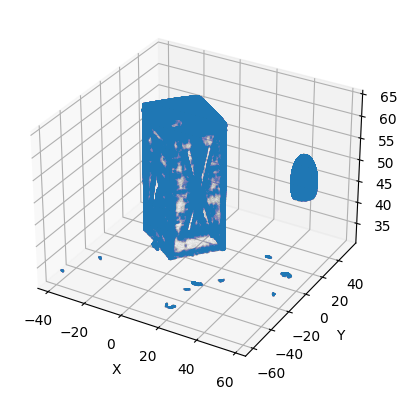

In [8]:
display(raw_data)

In [9]:
min_y = min(raw_data[:, Y])
max_z = max(raw_data[:, Z])
min_z = min(raw_data[:, Z])

def is_btm(pt):
    return abs(pt[Z] - min_z) <= 0.2

def is_top(pt):
    return abs(max_z - pt[Z]) <= 0.2


In [10]:
top_layer = np.array([pt for pt in raw_data if is_top(pt)])

top_layer.shape

(121683, 3)

In [11]:
def aggregate_h_by_xy(points):

    table = {}

    for pt in points:
        x, y, z = pt
        
        key = (round(x, 2), round(y, 2))

        if key not in table:
            table[key] = z
        else:
            table[key] = max(table[key], z)

    return table

def crop(points):

    z_table = aggregate_h_by_xy(points)

    max_z = max(points[:, Z])

    def is_cube(pt):
        x, y, _ = pt
        key = (round(x, 2), round(y, 2))
        return max_z - z_table[key] < 10

    return np.array([pt for pt in points if is_cube(pt)])

In [12]:
cube = crop(raw_data)

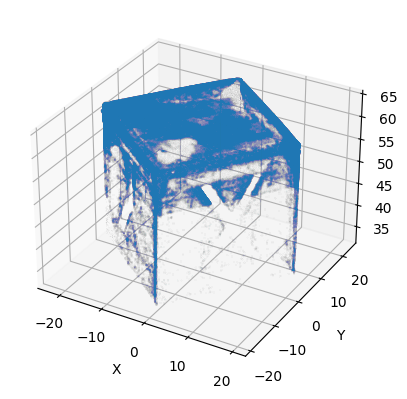

In [13]:
display(cube)

In [14]:
def closest_points_count(points):
    top_layer = np.array([pt for pt in points if is_top(pt)])

    min_y = min(points[:, Y])

    def is_min(pt):
        return abs(pt[Y] - min_y) <= 1

    return len([pt for pt in points if is_min(pt)])

In [15]:
# takes 2 min to run on my laptop
def best_degree_for_rotation(points):

    best_count = 0
    best_degree = 0

    for d in range(90):
        rotated = rotate_z(points, d)

        n = closest_points_count(rotated)

        print(f'd={d}, n={n}')

        if n > best_count:
            best_count = n
            best_degree = d

    return best_degree

# takes 16s to run on my laptop
def best_degree_for_rotation_bisearch(points):

    l, r = 0, 90

    while r - l > 0.01:
        mid = (l + r) / 2

        n = closest_points_count(rotate_z(points, mid))
        rt = closest_points_count(rotate_z(points, mid + 2))
        lf = closest_points_count(rotate_z(points, mid - 2))

        # print(mid, lf, n, rt)

        if n > rt and n > lf:
            break
        elif n > rt and n < lf:
            r = mid
        else:
            l = mid + 0.1

    return mid

In [16]:
d = best_degree_for_rotation_bisearch(cube)

print(f'rotate {d} degrees to align with axises')

rotate 36.675 degrees to align with axises


In [17]:
aligned_cube = rotate_z(cube, d)

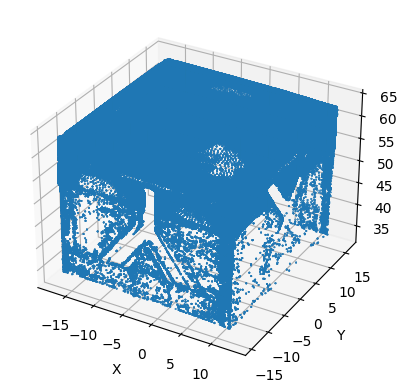

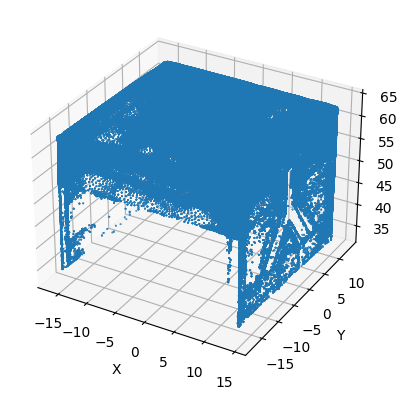

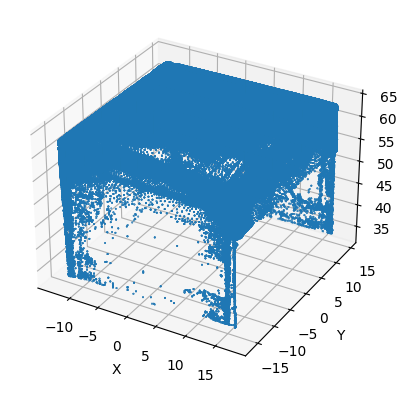

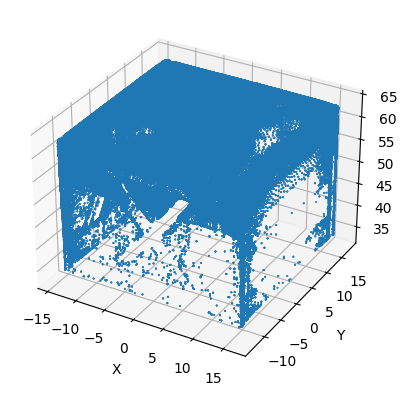

In [18]:
for i in range(4):
    display(rotate_z(aligned_cube, i * 90), s=0.1)

In [19]:
def rotate_to_x(points):
    pass

def crop_h10(points):
    
    max_z = max(points[:, Z])

    return np.array([pt for pt in points if max_z - pt[Z] <= 10])

In [20]:
top_cube = crop_h10(aligned_cube)

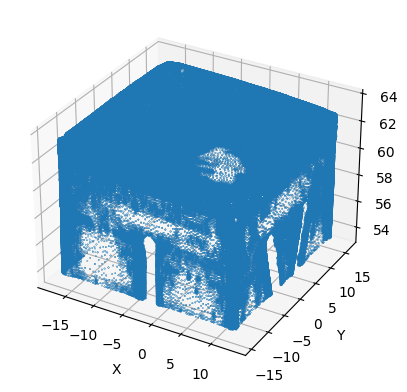

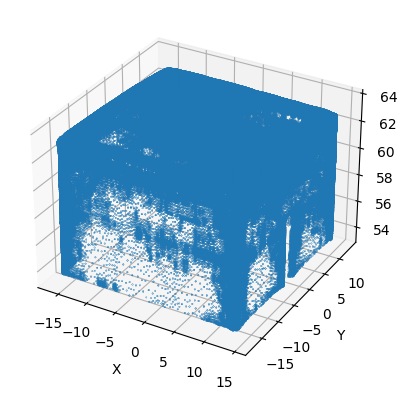

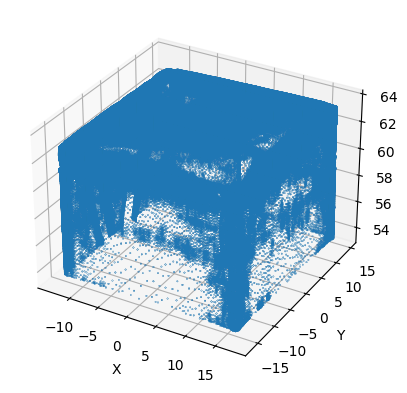

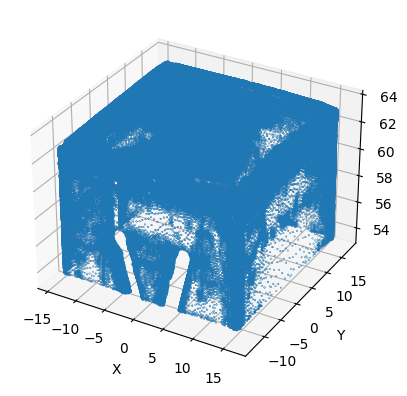

In [21]:
for i in range(4):
    display(rotate_z(top_cube, i * 90), s=0.01)

In [22]:
def get_closest_surface(points):
    min_y = min(points[:, Y])

    def is_close(pt):
        return abs(pt[Y] - min_y) < 3

    xyz = np.array([pt for pt in points if is_close(pt)])
    return xyz[:, [X, Z]]

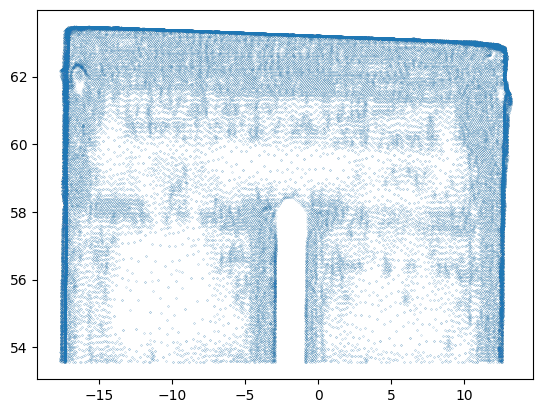

In [23]:
xy = get_closest_surface(top_cube)
plt.scatter(xy[:, 0], xy[:, 1], s=0.001)

In [24]:
def xy_grid(xy, row=50, col=50):
    xs = xy[:, X]
    ys = xy[:, Y]

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    # print(f'x: [{min_x}, {max_x}], y: [{min_y}, {max_y}]')
    
    x_range = (max_x - min_x) / col
    y_range = (max_y - min_y) / row

    # print(f'x range: {x_range}, y range: {y_range}')

    ans = np.zeros((row, col))

    for x, y in xy:
        c = int((x - min_x) // x_range) 
        r = int((y - min_y) // y_range)

        if r == row:
            r -= 1
        if c == col:
            c -= 1

        try:
            ans[r][c] = 1
        except IndexError:
            print(f'({x}, {y}) -> ({r}, {c})')
            return None

    return ans[::-1]

def display_grid(xy):
    fig, ax = plt.subplots()
    im = ax.imshow(xy)
    plt.show()

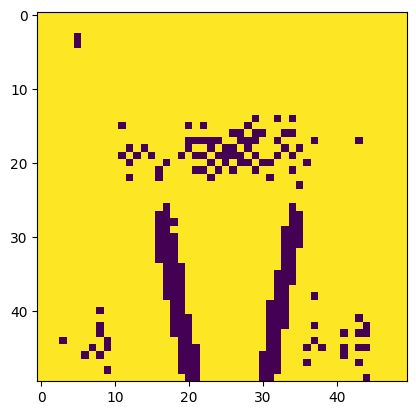

In [25]:
display_grid(xy_grid(get_closest_surface(rotate_z(top_cube, 270))))

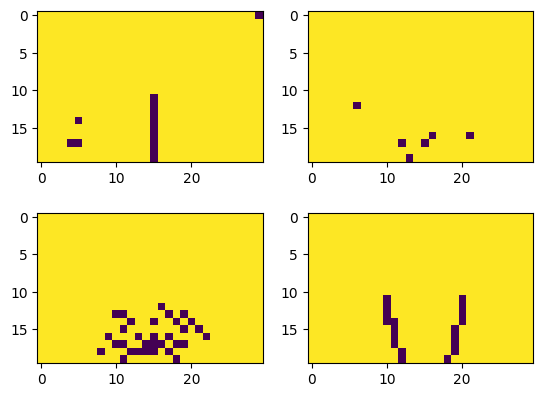

In [26]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2)

for i in range(4):
    r = int(i // 2)
    c = i % 2

    xyz = rotate_z(top_cube, i * 90)
    xy = get_closest_surface(xyz)
    grid = xy_grid(xy, row=20, col=30)
    im = ax[r, c].imshow(grid)
    # plt.colorbar(im, ax=ax[i, j])

plt.show()

In [27]:
def degrees_to_Y(top_cube):
    for i in range(4):
        xyz = rotate_z(top_cube, i * 90)
        xy = get_closest_surface(xyz)

        R, C = 20, 30

        grid = xy_grid(xy, row=R, col=C)

        for c in range(C):

            r = R - 1

            if grid[r][c] == 1:
                continue

            while r >= 0 and grid[r][c] == 0:
                r -= 1

            n = R - 1 - r

            if n > 5:
                return i * 90
    raise RuntimeError('cannot find degree to Y')

In [684]:
# grid = xy_grid(get_closest_surface(rotate_z(top_cube, 0)), row=20, col=30)

0

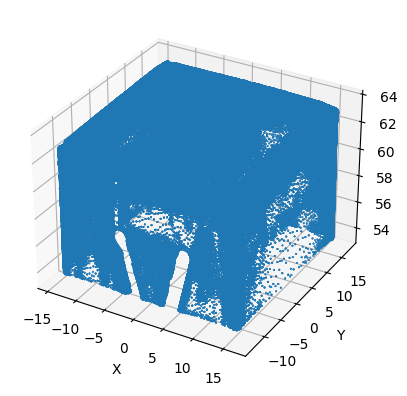

In [28]:

display(rotate_z(top_cube, degrees_to_Y(top_cube) - 90), s=0.1)

In [29]:
def get_top_layer(xyz):
    max_z = max(xyz[:, Z])

    def is_top_z(z):
        return max_z - z <= 0.5
    
    return np.array([pt for pt in xyz if is_top_z(pt[Z])])


In [30]:
xyz = rotate_z(top_cube, degrees_to_Y(top_cube) - 90)
final = rotate_x(get_top_layer(xyz), 90)[:, [X, Z]]

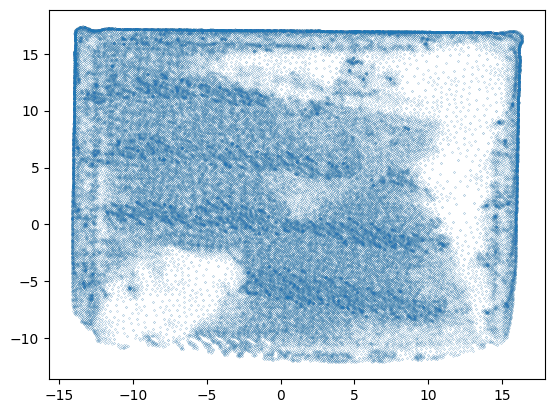

In [31]:
plt.scatter(final[:, 0], final[:, 1], s=0.001)